# Introduction
In this project ....

We will simulate a very simple system consisting of a cart driven by a DC motor. The states of the system are the cart's _position_ $x_1$, its _velocity_ $x_2$, and the applied _armature current_ $x_3$, such that the state vector is given by
$$
\mathbf{x} = 
\begin{bmatrix}
x_1 \\ x_2 \\ x_3
\end{bmatrix}.
$$

To model this system, we must establish the relationship between the state variables. For the position and velocity, the relationship is simply 
$$
\dot{x}_1 = x_2.
$$

For the velocity and the armature current, we begin by investigating the forces acting on the cart. They are the driving force $F_M$ developed by the electric motor, and the opposing friction $F_r$. In sum, the cart's acceleration is given by
$$
\dot{x}_2 = \frac{F_M - F_r}{m},
$$
where $m$ is the mass of the cart. The motor force is proportional to the torque, $T_M$, and the torque developed by DC motor is again proportional to the applied armature current, such that
$$
F_M = k_M T_M = k_M'x_3.
$$
Here, $k_M$ contains all factors relating to the mechanical transmission of power from the rotor to the surface which the cart's wheels are rubbing against, while $k_M'$ in addition to that accounts for the electromagnetics, such as flux density, rotor area and physical constants. In the case we are studying here, the friction increases linearly with velocity;
$$
F_r = k_r x_2,
$$
where $k_r$ is the friction constant. This kind of friction is typical for an object moving slowly through a viscous without creating turbulence. The resulting relationship between velocity and armature current is
$$
\dot{x}_2 = \frac{-k_r}{m}x_2 + \frac{k_M'}{m}x_3.
$$

Moving on to the armature current equation, we note that we can only control the cart's position and velocity through current. A step change in setpoint from a steady-state $u^-$ to $u^+$ at time $t=0$ gives an exponential response in the armature current due to electrical impedance, such that
$$
x_3 = u^- + \big( 1 - e^{-t/\tau_a} \big) \big( u^+ - u^- \big), \quad t \ge 0.
$$
Time derivation gives us
$$
\dot{x}_3 = \frac{1}{\tau_a} \bigg[ \big( u^+ - u^- \big)e^{-t/\tau_a} \bigg],
$$
and rearranging the equation for $x_3$ above gives us that
$$
x_3 = u^+ - \bigg[ \big( u^+ - u^- \big)e^{-t/\tau_a} \bigg] = u^+ - \tau_a \dot{x}_3,
$$
which results in
$$
\dot{x}_3 = \frac{-1}{\tau_a} x_3 + \frac{1}{\tau_a} u^+.
$$

Finally, the system equiation becomes
$$
\dot{\mathbf{x}} = \mathbf{F}\mathbf{x} + \mathbf{L}u
\quad \Rightarrow \quad
\begin{bmatrix}
\dot{x}_1 \\ \dot{x}_2 \\ \dot{x}_3
\end{bmatrix}
=
\begin{bmatrix}
0 & 1 & 0 \\
0 & \frac{-k_r}{m} & \frac{k_M'}{m} \\
0 & 0 & \frac{-1}{\tau_a}
\end{bmatrix}
\begin{bmatrix}
x_1 \\ x_2 \\ x_3
\end{bmatrix}
+
\begin{bmatrix}
0 \\ 0 \\ \frac{1}{\tau_a}
\end{bmatrix}
u.
$$

# 1 Simulation Model $\mathcal{M^S}$

In the assignment, we are given the following parameters to work with:
$$
\frac{k_r}{m} = \frac{k_M'}{m} = \frac{1}{T_2}, \quad \text{and} \quad \tau_a = T_3.
$$
Looking at the second system equation, for velocity $x_2$, we see that it has similar shape as the armature current equation. The equality $k_r = k_M'$ thus means that the value of $x_2, x_3$ and $u$ are equal in the steady state. Also, we should expect a similar exponential response in $x_2$ to a step change in $x_3$ as we saw for the armature current equation above, only with a time constant $T_2$ instead of $T_3$. However, since change in $x_2$ is a reaction to change in $x_3$, and $x_3$ is a reaction to (instant) change in $u$, the response in $x_2$ will be slower than what we should expect from its time constant alone.

The assignment also provides us with a noise term in the system equation, affecting only armature current, such that the equation gets the form
$$
\dot{\mathbf{x}} = \mathbf{F}\mathbf{x} + \mathbf{L}u + \mathbf{G}v
\quad \Rightarrow \quad
\begin{bmatrix}
\dot{x}_1 \\ \dot{x}_2 \\ \dot{x}_3
\end{bmatrix}
=
\begin{bmatrix}
0 & 1 & 0 \\
0 & \frac{-1}{T_2} & \frac{1}{T_2} \\
0 & 0 & \frac{-1}{T_3}
\end{bmatrix}
\begin{bmatrix}
x_1 \\ x_2 \\ x_3
\end{bmatrix}
+
\begin{bmatrix}
0 \\ 0 \\ \frac{1}{T_3}
\end{bmatrix}
u
+
\begin{bmatrix}
0 \\ 0 \\ 1
\end{bmatrix}
v, \quad v \sim \mathcal{N}(0, \tilde{\mathbf{Q}} \delta(t-\tau)).
$$

We will assume initial state estimate $\hat{\mathbf{x}}_0 = \mathbf{0}$, such that the initial estimate error covariance becomes
$$
\mathbf{x}_0 = \hat{\mathbf{e}}_0 \sim \mathcal{N}(0, \hat{\mathbf{P}}_0).
$$
Later, when we discuss the Kalman filter, we will assume measurement of position only. The measurement equation then becomes
$$
\mathbf{z}_k = \mathbf{Hx} + \mathbf{w}_k
\quad \Rightarrow \quad
z_k = 
\begin{bmatrix}
1 & 0 & 0
\end{bmatrix}
\mathbf{x}
+ w_k, \quad w_k \sim \mathcal{N}(0, \mathbf{R} \delta_{kl}).
$$


Having established the system equation and roughly what to expect in terms of changes in the control parameter $u$, we are ready to run simulations. But, before we start, let's set up our Python environment: 

In [59]:
### Setting up environment
%load_ext autoreload
import numpy as np
from numpy import sqrt
from scipy.linalg import expm, inv, norm, cholesky as chol
import matplotlib.pyplot as plt
from tqdm import tqdm

### Setting plotting style
plt.style.use('fivethirtyeight')
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

### Seed the RNG
np.random.seed(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's also define a function which will help us give matrices a square form by padding them with zeros along the missing rows or columns: 

In [60]:
def pad_to_square(A, n=None):
    '''Zero pads matrix A to square shape'''
    nx, ny = A.shape
    if n is None:
        n = max(nx, ny)
    B = np.zeros((n,n))
    B[:nx, :ny] = A
    return B

Parameters for the simulation model are listed below.

In [61]:
# Simulation parameters
t0, tf = 0, 100
dt = .01

# System parameters
T2, T3 = 5, 1
Q = np.eye(3)*2*.1**2
F = np.array([[0, 1, 0],
              [0, -1/T2, 1/T2],
              [0, 0, -1/T3]])
L = np.array([[0, 0, 0],
              [0, 0, 0],
              [0, 0, 1/T3]])
G = np.array([[0, 0, 0],
              [0, 0, 0],
              [0, 0, 1]])

# Kalman filter parameters
P0 = np.diag([1, .1**2, .1**2])
R = np.eye(3)*1
H = np.array([[1, 0, 0],
              [0, 0, 0],
              [0, 0, 0]])

# 2 Discretization

To implement the system equation in a computer program we need first to discretize it into the form
$$
\mathbf{x}_{x+1} = \mathbf{\Phi}\mathbf{x}_k + \mathbf{\Lambda}\mathbf{u}_k + \mathbf{\Gamma}\mathbf{v}_k, \quad \mathbf{v}_k \sim \mathcal{N}(0, \mathbf{Q} \delta_{kl}).
$$
Here, $\mathbf{u}_k = [u_k, 0, 0]^T$ and $\mathbf{v}_k = [0, 0, v_k]^T$. We also point out that $\tilde{\mathbf{Q}}$ in the continuous equation is the process noise power spectral density matrix -- which is a continuous function in $\mathbb{R}^{n \times n}$ -- and that the corresponding factor in the discrete equation $\mathbf{Q}$ is the discrete process noise autocorrelation matrix.

The discrete system matrices $\mathbf{\Phi}, \mathbf{\Lambda}$ are found by first re-writing the deterministic part of the continuous system equation as
$$
\dot{\tilde{\mathbf{x}}} = \tilde{\mathbf{F}}\tilde{\mathbf{x}} = 
\begin{bmatrix}
\mathbf{F} & \mathbf{L} \\
\mathbf{0} & \mathbf{0}
\end{bmatrix}
\begin{bmatrix}
\mathbf{x} \\
\mathbf{u}
\end{bmatrix}.
$$
Then, the corresponding deterministic discrete equation becomes
$$
\tilde{\mathbf{x}}_{k+1} = \tilde{\mathbf{\Phi}}\tilde{\mathbf{x}}_k, 
\quad \text{where} \quad 
\tilde{\mathbf{\Phi}} = e^{\tilde{\mathbf{F}} \Delta t} =
\begin{bmatrix}
\mathbf{\Phi} & \mathbf{\Lambda} \\
\mathbf{0} & \mathbf{I}
\end{bmatrix},
$$
and we assume that $u$ is constant over the time interval $[t_k, t_k + \Delta t]$. An implementation follows below.

In [62]:
def c2d_determnistic(F, L, dt):
    '''Converts the continuous process equation matrices F, L into discrete matrices Fi, La with time step dt'''
    p = F.shape[0]
    F1 = pad_to_square(np.hstack((F, L)), n=2*p)
    Fi1 = expm(F1*dt)
    Fi = Fi1[:p, :p]  # Upper left
    La = Fi1[:p, p:]  # Upper right
    
    return (Fi, La)

Running this with the input defined in the assignment we ge get the result printed below. We note that the discretized control input matrix $\Lambda$ does not have all-zeros in the first and second rows, for the position and velocity equations. The reason for this is that we account for the effect on position and velocity in the time interval $[t_k, t_k + \Delta t]$, which follows from the matrix superposition integral:
$$
\mathbf{\Lambda}\mathbf{u}_k = \int_{t_k}^{t_k + \Delta t} \mathbf{\Phi}\mathbf{L}\mathbf{u}(\tau) d\tau .
$$

In [63]:
Fi, La = c2d_determnistic(F, L, dt)
Fi, La

(array([[1.00000000e+00, 9.99000666e-03, 9.96010313e-06],
        [0.00000000e+00, 9.98001999e-01, 1.98804123e-03],
        [0.00000000e+00, 0.00000000e+00, 9.90049834e-01]]),
 array([[0.00000000e+00, 0.00000000e+00, 3.32335397e-08],
        [0.00000000e+00, 0.00000000e+00, 9.96010313e-06],
        [0.00000000e+00, 0.00000000e+00, 9.95016625e-03]]))

Moving on, we find $\mathbf{\Gamma}$ in a similar way as above by considering only the stochastic part of the continuous system equation, such that
$$
\dot{\tilde{\tilde{\mathbf{x}}}} = \tilde{\tilde{\mathbf{F}}} \tilde{\tilde{\mathbf{x}}} = 
\begin{bmatrix}
\mathbf{F} & \mathbf{G}\tilde{\mathbf{Q}}\mathbf{G}^T \\
\mathbf{0} & -\mathbf{F}^T
\end{bmatrix}
\begin{bmatrix}
\mathbf{x} \\
\mathbf{z}'
\end{bmatrix},
$$
This is the solution of the Riccati equation for the error covariance;
$$
\dot{\mathbf{P}} = \mathbf{FP} + \mathbf{FP}^T - \mathbf{PH}^T \mathbf{R}^{-1} \mathbf{HP} + \mathbf{G}\tilde{\mathbf{Q}}\mathbf{G}^T,
$$
and $\mathbf{z}'$ in the augmented state vector is defined such that
$$
\mathbf{P}\mathbf{z}' = \mathbf{x}.
$$
We then get that the stochastic part of the system equation can be discretized as
$$
\tilde{\tilde{\mathbf{x}}}_{k+1} = \tilde{\tilde{\mathbf{\Phi}}} \tilde{\tilde{\mathbf{x}}}_k, 
\quad \text{where} \quad 
\tilde{\tilde{\mathbf{\Phi}}} = e^{\tilde{\tilde{\mathbf{F}}} \Delta t} =
\begin{bmatrix}
\tilde{\tilde{\mathbf{\Phi}}}_{11} & \tilde{\tilde{\mathbf{\Phi}}}_{12} \\
\mathbf{0} & \tilde{\tilde{\mathbf{\Phi}}}_{22}
\end{bmatrix},
$$
where
$$
\mathbf{\Phi} = \tilde{\tilde{\mathbf{\Phi}}}_{11}, \quad \text{and} \quad \mathbf{\Gamma}\mathbf{Q}\mathbf{\Gamma}^T = \tilde{\tilde{\mathbf{\Phi}}}_{12} \tilde{\tilde{\mathbf{\Phi}}}_{22}^{-1}.
$$
By letting $\mathbf{Q} = \mathbf{I}$, and hence scaling $\mathbf{\Gamma}$ correspondingly, we find $\mathbf{\Gamma}$ by the upper Cholesky factorization
$$
\mathbf{\Gamma} = \mathrm{chol}_u \bigg[ \tilde{\tilde{\mathbf{\Phi}}}_{12} \tilde{\tilde{\mathbf{\Phi}}}_{22}^{-1} \bigg].
$$
An implementation of this is given here:

In [64]:
def c2d_stochastic(F, L, G, Q, dt):
    '''Converts the continuous process equation matrices F, L, G, Q into discrete matrices Fi, La, Ga with time step dt'''
    p = F.shape[0]
    GQGT = pad_to_square(G@Q@G.T, n=p)
    F2 = np.vstack((np.hstack((F, GQGT)),
                    np.hstack((np.zeros(F.shape), -F.T))))
    Fi2 = expm(F2*dt)
    Fi12 = Fi2[:p, p:]  # Upper right
    Fi22 = Fi2[p:, p:]  # Lower right
    Ga = chol(Fi12 @ inv(Fi22), lower=False)
    Fi, La = c2d_determnistic(F, L, dt)
    
    return (Fi, La, Ga)

Running this again with the parameters defined in the assignment we get the result shown below. We note again that the contribution from process noise is not restricted to armature current, and that this again results from the matrix superposition integral applied on the noise:
$$
\mathbf{\Gamma}\mathbf{v}_k = \int_{t_k}^{t_k + \Delta t} \mathbf{\Phi}\mathbf{G}\mathbf{v}(\tau) d\tau .
$$

In [65]:
Fi, La, Ga = c2d_stochastic(F, L, G, Q, dt)
Fi, La, Ga

(array([[1.00000000e+00, 9.99000666e-03, 9.96010313e-06],
        [0.00000000e+00, 9.98001999e-01, 1.98804123e-03],
        [0.00000000e+00, 0.00000000e+00, 9.90049834e-01]]),
 array([[0.00000000e+00, 0.00000000e+00, 3.32335397e-08],
        [0.00000000e+00, 0.00000000e+00, 9.96010313e-06],
        [0.00000000e+00, 0.00000000e+00, 9.95016625e-03]]),
 array([[6.30352113e-08, 1.57378158e-05, 1.04656845e-02],
        [0.00000000e+00, 4.07432794e-06, 8.14187293e-03],
        [0.00000000e+00, 0.00000000e+00, 4.71090429e-03]]))

# 3 Simulation of Stochastic System

We will now simulate the system, first as a purely deterministic process, and then as a stochastic process (i.e. including process noise). We define two methods, one which runs a simulation of the deterministic process, and one which runs a simulation of a stochastic process:

In [66]:
def run_deterministic(u, Fi, La):
    '''Runs simulation of deterministic system Fi, La with control vector u.'''
    _, n = u.shape
    x = np.zeros(u.shape)
    
    for k in range(n-1):
        x[:,k+1,np.newaxis] = Fi@x[:,k,np.newaxis] + La@u[:,k,np.newaxis]
    
    return x

In [67]:
def run_stochastic(u, v, Fi, La, Ga):
    '''Runs simulation of stochastic system Fi, La, Ga with control vector u and noise vector v.'''
    _, n = u.shape
    x = np.zeros(u.shape)
    
    for k in range(n-1):
        x[:,k+1,np.newaxis] = Fi@x[:,k,np.newaxis] + La@u[:,k,np.newaxis] + Ga@v[:,k,np.newaxis]
    
    return x

In the assignment, we are given a fixed control input $u = 1$, such that we can define the control vector ```u``` as ...

In [68]:
t = np.arange(0., tf+dt, dt)
n = t.size
u = np.zeros((3,n))
u[2,:] = 1
u

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.]])

... and run the deterministic process simulation which is stored in the vector ```xd```:

In [69]:
# Deterministic process
Fi, La = c2d_determnistic(F, L, dt)
xd = run_deterministic(u, Fi, La)

For the stochastic process we define in addition a noise vector ```v``` and run the stochastic process simulation which we store in vector ```xs```:

In [70]:
v = np.zeros((3,n))
v[2,:] = np.random.randn(n)
Fi, La, Ga = c2d_stochastic(F, L, G, Q, dt)
xs = run_stochastic(u, v, Fi, La, Ga)

Below we see a plot of each of the processes, showing the armature current control input $u(k)$, the deterministic velocity estimate $\hat{x}_2^{(d)}(k)$, and the stochastic estimate $\hat{x}_2^{(s)}(k)$. The velocity transient response to the step change in $u$ is eponential, as we expected from the discussion above, and in the deterministic curve we see that it is slighly damped due to the damped reponse in armature current $x_3$. Further, and also as expected, we see that there is a 1-to-1 relationship bewtween the control input and the velocity in the steady state, except of course for the noise effect in the stochastic case.

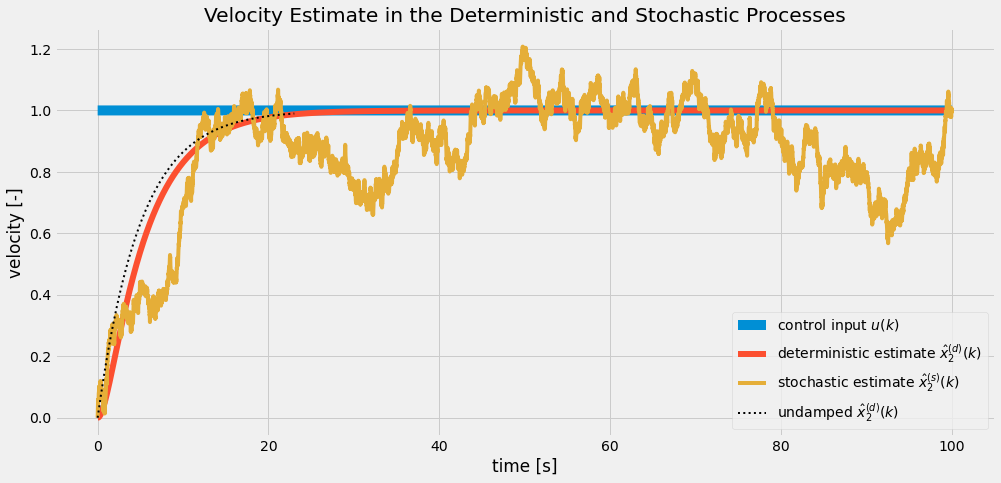

In [71]:
fig, axes = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=True, figsize=(15,7))

ax = axes
ax.set_title(r'Velocity Estimate in the Deterministic and Stochastic Processes')
ax.plot(t, u[2], lw=10)
ax.plot(t, xd[1], lw=6)
ax.plot(t, xs[1], lw=4)
ax.plot(t[(m:=(x:=1-np.exp(-t/T2))<.99)], x[m], lw=2, ls=':', color='0')
ax.legend([r'control input $u(k)$', r'deterministic estimate $\hat{x}_2^{(d)}(k)$', r'stochastic estimate $\hat{x}_2^{(s)}(k)$', r'undamped $\hat{x}_2^{(d)}(k)$'])
ax.set_xlabel('time [s]')
ax.set_ylabel('velocity [-]')
plt.show()

# 4 Optimal Kalman Filter

We will now implement the discrete Kalman filter for the system studied above. The discrete Kalman filter is an algorithm running in a loop, updating an a-priori estimate of the state $\bar{\mathbf{x}}_k$ with an a-posteriori estimate $\hat{\mathbf{x}}_k$ after taking the noisy measurement $\mathbf{z}_k$ into account;
$$
\hat{\mathbf{x}}_k = \bar{\mathbf{x}}_k + \mathbf{K}_k (\bar{\mathbf{z}}_k - \mathbf{H}\bar{\mathbf{x}}_k)
$$
$\mathbf{K}_k$ is the Kalman gain. The Kalman gain is a weight factor which in the _optimal_ case minimizes the expected state estimate error $\hat{\mathbf{e}}_k = \mathbf{x}_k - \hat{\mathbf{x}}_k$ in the minimum-variance sense. That is, at each time step $k$, the Kalman gain is set such that it minimizes $\mathbb{E} \big[ \hat{\mathbf{e}}_k \hat{\mathbf{e}}_k^T \big]$. This leads to the update equation
$$ 
\mathbf{K}_k = \bar{\mathbf{P}}_k \mathbf{H}^T (\mathbf{H} \bar{\mathbf{P}}_k \mathbf{H}^T + \mathbf{R})^{-1},
$$
where $\bar{\mathbf{P}}_k$ is the "a-priori" estimate of the error covariance matrix. We initially set $\bar{\mathbf{P}}_0 = \mathbf{P}_0$ and use this together with the Kalman gain to get an improved, "a-posteriori" estimate $\hat{\mathbf{P}}_0$, given by (for general time $k$)
$$
\hat{\mathbf{P}}_k = (\mathbf{I} - \mathbf{K}_k \mathbf{H}) \bar{\mathbf{P}}_k.
$$
We then use $\hat{\mathbf{P}}_k$ to recursively calculate the next-step a-priori covariance as
$$
\bar{\mathbf{P}}_{k+1} = \mathbf{\Phi} \hat{\mathbf{P}}_k \mathbf{\Phi}^T + \mathbf{\Gamma} \mathbf{Q} \mathbf{\Gamma}^T
$$
before we repeat the process. As a sidenote we mention that the Kalman gain and state error covariance can be calculated without actually take any measurements of the process, as long as we know its (possibly varying) statistics. But, in our application we will also take measurements, and we use the deterministic system equation from above to give us the a-priori state estimate:
$$
\bar{\mathbf{x}}_{k+1} = \mathbf{\Phi} \hat{\mathbf{x}}_k + \mathbf{\Lambda} \mathbf{u}_k.
$$

An implemenation of the discrete Kalman filter algorithm which filters the measurements ```z``` with control input ```u``` follows below. The ```mi``` parameter, for measurement interval, lets us define a sample frequency for the process simulation. Note that this implementation could very easily have been made much more efficient by pre-calculating some of the matrix products, but we skip that for clarity.

In [72]:
def kalman_filter(z, u, Fi, La, Ga, P0, H, R, mi, suboptimal=False):
    '''
    Filters the measurements z taken at intervals mi through the Kalman filter defined by 
    Fi, La, Ga, with measurement parameters H with statistics R. Control input u and initial
    state estimate error covariance P0.
    
    Returns tuple (x_bar, x_hat, p_bar, p_hat)
    '''
        
    # System order and simulation length
    p, nm = z.shape
    _, n = u.shape
    I = np.eye(p)
    
    # State vector estimates
    x_bar = np.zeros((p,n))  # a-priori
    x_hat = np.zeros((p,nm))  # a-posteriori

    # Covariance matrice estimates
    P_bar = np.zeros((n,p,p))  # a-priori
    P_bar[0] = P0
    P_hat = np.zeros((nm,p,p))  # a-posteriori
    
    # Run simulation
    for k in range(n-1):
        
        # Measurement update
        if k%mi == 0:
            km = k//mi
            
            # Compute Kalman gain
            Kk = P_bar[k]@H.T@inv(H@P_bar[k]@H.T + R)

            # Update a-posteriori estimates
            x_hat[:,km,np.newaxis] = x_bar[:,k,np.newaxis] + Kk@(z[:,km,np.newaxis] - H@x_bar[:,k,np.newaxis])
            P_hat[km] = (I - Kk@H)@P_bar[k]
            
            if suboptimal:
                P_hat[km] += P_bar[k]@(I - Kk@H).T + Kk@R@Kk.T

        # Time update - update a-priori estimates
        x_bar[:,k+1,np.newaxis] = Fi@x_hat[:,km,np.newaxis] + La@u[:,k,np.newaxis]
        P_bar[k+1] = Fi@P_hat[km]@Fi.T + Ga@Ga.T
    
    # Extract diagonals
    p_bar = np.array([P_bar[:,i,i] for i in range(p)])
    p_hat = np.array([P_hat[:,i,i] for i in range(p)])
    
    return (x_bar, x_hat, p_bar, p_hat)


We will filter measurements of the sochastic system simulation from part 3 above and see if the Kalman filter gives us a better state estimate than the measurements alone will give us. We ran the stochastic simulation with time step $\Delta t = 0.01$ second, but will take measurements only once per second. The measurement interval parameter ```mi``` is thus set to 100, and sample ```xs``` with noise ```w```:

In [73]:
# Measurement update interval
mi = 100

# Take measurements
xm = xs[:,:-1:mi]
_, nm = xm.shape
w = np.zeros((3,nm))
w[0] = np.random.randn(nm)
z = H@xm + w

If we would rely only on measurements, we would get the estimates
$$
\begin{aligned}
\check{x}_1(t_k) &= z_1(t_k) \\
\check{x}_2(t_k) &= \frac{\check{x}_1(t_k) - \check{x}_1(t_k - \Delta t)}{\Delta t} \\
\check{x}_3(t_k) &= \check{x}_3(t_k - \Delta t) + \big( 1 - e^{-\Delta t/T_3} \big) \big( u_3(t_k) - \check{x}_3(t_k - \Delta t) \big)
\end{aligned},
$$
which can see plotted together with the repective true state variable below. We see that the direct measurement give estimates which are _far_ from the true values, especially for velocity. We will see next if the Kalman filter can give us better results than these.

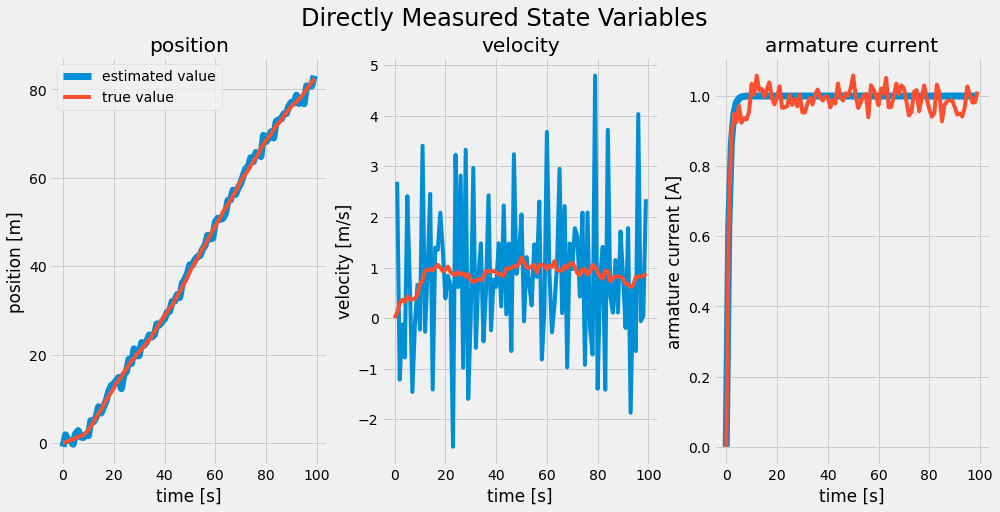

In [74]:
fig, axes = plt.subplots(ncols=3, nrows=1, sharex=True, sharey=False, figsize=(15,7))
fig.suptitle(r'Directly Measured State Variables', fontsize=24)

tm = np.linspace(t0, tf, nm, endpoint=False)

ax = axes[0]
ax.set_title(r'position')
ax.plot(tm, z[0], lw=7)
ax.plot(tm, xm[0])
ax.legend(['estimated value', 'true value'])
ax.set_ylabel('position [m]')
ax.set_xlabel('time [s]')

ax = axes[1]
ax.set_title(r'velocity')
ax.plot(tm[1:], z[0,1:]-z[0,:-1])
ax.plot(tm, xm[1])
ax.set_ylabel('velocity [m/s]')
ax.set_xlabel('time [s]')
           
ax = axes[2]
ax.set_title(r'armature current')
x3 = np.zeros(nm)
for k in range(1,nm):
    x3[k] = x3[k-1] + (1-np.exp(-mi*dt/T3))*(1 - x3[k-1])
ax.plot(tm, x3, lw=7)
ax.plot(tm, xm[2])
ax.set_ylabel('armature current [A]')
ax.set_xlabel('time [s]')

plt.show()

We must calculate a new set of discrete system matrices to account for the longer time step between measurements in the Kalman filter. Then we filter the measurements...

In [75]:
# Kalman filter matrices
FiK, LaK, GaK = c2d_stochastic(F, L, G, Q, dt*mi)

# Run simulation
(x_bar, x_hat, p_bar, p_hat) = kalman_filter(z, u, FiK, LaK, GaK, P0, H, R, mi)
e_bar = xs - x_bar  # a-priori estimate error
e_hat = xm - x_hat  # a-posteriori estimate error

... and plot once more the estimated states $\hat{x}_i$ together with the true values, as we did above. We that the Kalman filter _greatly_ improves the quality of the estimates, especially for the velocity, but also for position, which above would be up to a few meters off, but now overlaps almost perfectly with the true position. Armature current is more or less the same.

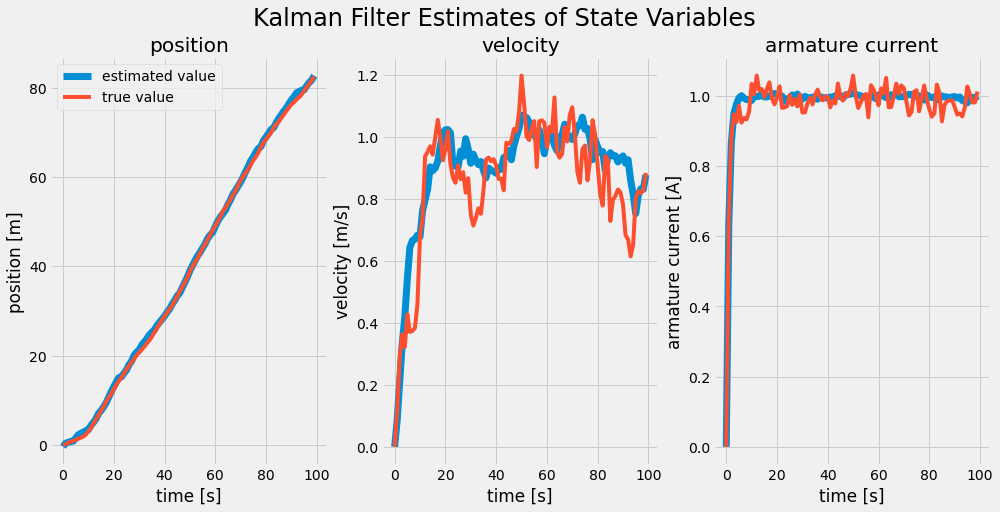

In [76]:
fig, axes = plt.subplots(ncols=3, nrows=1, sharex=True, sharey=False, figsize=(15,7))
fig.suptitle(r'Kalman Filter Estimates of State Variables', fontsize=24)

tm = np.linspace(t0, tf, nm, endpoint=False)

ax = axes[0]
ax.set_title(r'position')
ax.plot(tm, x_hat[0], lw=7)
ax.plot(tm, xm[0])
ax.legend([r'estimated value', 'true value'])
ax.set_ylabel('position [m]')
ax.set_xlabel('time [s]')

ax = axes[1]
ax.set_title(r'velocity')
ax.plot(tm, x_hat[1], lw=7)
ax.plot(tm, xm[1])
ax.set_ylabel('velocity [m/s]')
ax.set_xlabel('time [s]')
           
ax = axes[2]
ax.set_title(r'armature current')
ax.plot(tm, x_hat[2], lw=7)
ax.plot(tm, xm[2])

ax.set_ylabel('armature current [A]')
ax.set_xlabel('time [s]')

plt.show()

Below, in the first plot, we see velocity a-priori and a-posteriori estimates together with the true velocity and control input. We saw in the deterministic simulation that the control input $u$ translates 1-to-1 to velocity setpoint, but that the noise will cause it to miss that target. In the general case, the a-posteriori estimate should be better than the a-priori estimate, but from the curves in the first plot that conclusion cannot be drawn easily. Better then to look at the estimate errors, which are presented in the next plots. We have defined the errors
$$
\begin{aligned}
\bar{e}_2(k) &= x_2(k) - \bar{x}_2(k) \\
\hat{e}_2(k) &= x_2(k) - \hat{x}_2(k)
\end{aligned}
$$

We see that both estimates do not deviate too much beyond the first standard deviation, and in the last plot we also see that there is a slight improvement from a-priori to a-posteriori.

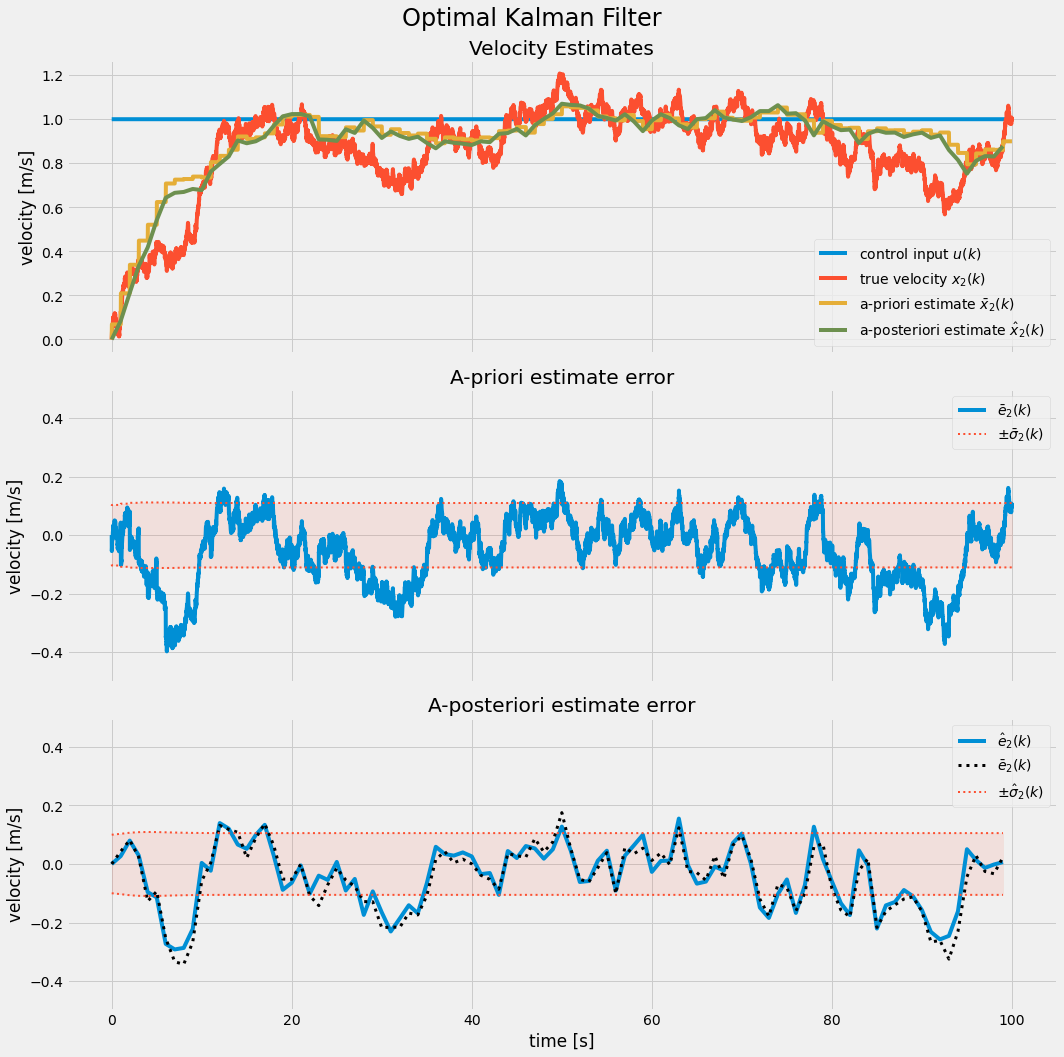

In [77]:
fig, axes = plt.subplots(ncols=1, nrows=3, sharex=True, sharey=False, figsize=(15,15))
fig.suptitle(r'Optimal Kalman Filter', fontsize=24)

tm = np.linspace(t0, tf, nm, endpoint=False)

ax = axes[0]
ax.set_title('Velocity Estimates')
ax.plot(t, u[2])
ax.plot(t, xs[1])
ax.plot(t, x_bar[1])
ax.plot(tm, x_hat[1])
ax.legend([r'control input $u(k)$', r'true velocity $x_2(k)$', r'a-priori estimate $\bar{x}_2(k)$', r'a-posteriori estimate $\hat{x}_2(k)$'])
ax.set_ylabel('velocity [m/s]')

ax = axes[1]
ax.set_title('A-priori estimate error')
ax.plot(t, e_bar[1])
ax.plot(t, sqrt(p_bar[1]), color=COLORS[1], lw=2, ls=':')
ax.plot(t, -sqrt(p_bar[1]), color=COLORS[1], lw=2, ls=':')
ax.fill_between(t, sqrt(p_bar[1]), -sqrt(p_bar[1]), color=COLORS[1], alpha=.1)
ax.set_ylim((-.5,.5))
ax.legend([r'$\bar{e}_2(k)$', r'$\pm \bar{\sigma}_2(k)$'], loc='upper right')
ax.set_ylabel('velocity [m/s]')

ax = axes[2]
ax.set_title('A-posteriori estimate error')
ax.plot(tm, e_hat[1], color=COLORS[0])
ax.plot(tm, e_bar[1,:-1:mi], color='0', lw=3, ls=':')
ax.plot(tm, sqrt(p_hat[1]), color=COLORS[1], lw=2, ls=':')
ax.plot(tm, -sqrt(p_hat[1]), color=COLORS[1], lw=2, ls=':')
ax.fill_between(tm, sqrt(p_hat[1]), -sqrt(p_hat[1]), color=COLORS[1], alpha=.1)
ax.set_ylim((-.5,.5))
ax.legend([r'$\hat{e}_2(k)$', r'$\bar{e}_2(k)$', r'$\pm \hat{\sigma}_2(k)$'], loc='upper right')
ax.set_ylabel('velocity [m/s]')
ax.set_xlabel('time [s]')

fig.tight_layout()
plt.show()

Below we see that the error reduction in the a-posteriori estimate is stronger for position and velocity than it is for armature current. This also fits well with what we saw when we compared the direct estimates with the Kalman filter estimates.

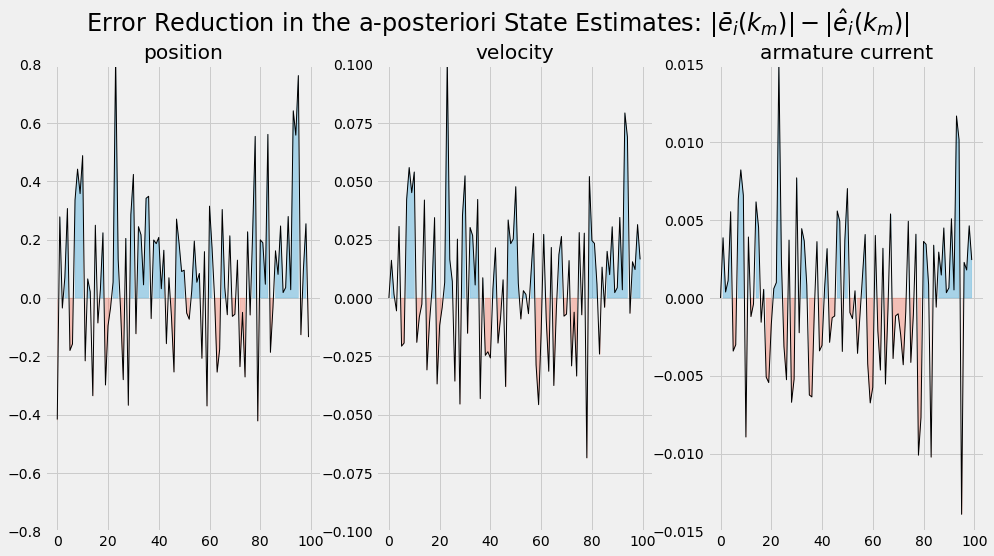

In [78]:
fig, axes = plt.subplots(ncols=3, nrows=1, sharex=True, sharey=False, figsize=(15,8))
fig.suptitle(r'Error Reduction in the a-posteriori State Estimates: $|\bar{e}_i(k_m)| - |\hat{e}_i(k_m)|$', fontsize=24)

titles = ('position', 'velocity', 'armature current')
e_diff = np.abs(e_bar[:,:-1:mi]) - np.abs(e_hat)
zero_line = np.zeros(e_diff.shape[1])

for i, title in enumerate(titles):
    ax = axes[i]
    ax.set_title(f'{title}')
    ax.plot(tm, e_diff[i], color='0', lw=1)
    ax.fill_between(tm, zero_line, e_diff[i], where=e_diff[i]>0, color=COLORS[0], alpha=.3)
    ax.fill_between(tm, zero_line, e_diff[i], where=e_diff[i]<0, color=COLORS[1], alpha=.3)
    
axes[0].set_ylim(-.8,.8)
axes[1].set_ylim(-.1,.1)
axes[2].set_ylim(-.015,.015)
plt.show()

Another feature of the Kalman filter which gives us an indication in the a-posteriori improvement is the update equiation for the a-posteriori covariance matrix, which should result in a reduction of error variance -- that is;
$$
\hat{\mathbf{P}}_k = (\mathbf{I} - \mathbf{K}_k \mathbf{H}) \bar{\mathbf{P}}_k \quad \Rightarrow \quad || \hat{\mathbf{P}}_k || < || \bar{\mathbf{P}}_k ||
$$
Below we see the error improvement statistics for our system, which also serves as a sanity check on our system model and implementation of the Kalman filter. We see the RMS sum of the covariance matrix diagonal elements.

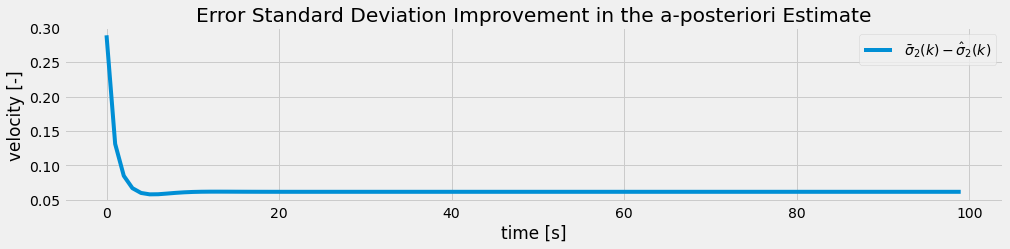

In [79]:
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(15,3))

ax = axes
ax.set_title('Error Standard Deviation Improvement in the a-posteriori Estimate')
ax.plot(sqrt(p_bar[:,:-1:mi].sum(axis=0)) - sqrt(p_hat.sum(axis=0)))
ax.set_ylabel('velocity [-]')
ax.set_xlabel('time [s]')
ax.legend([r'$\bar{\sigma}_2(k) - \hat{\sigma}_2(k)$'])
plt.show()

# 5 Monte Carlo simulation of optimal system

We will use Monte Carlo simulation to estimate the Kalman filter statistics for the velocity estimate;
$$
\begin{aligned}
\mathbb{E}[\hat{e}_2(k)] &\approx \hat{m}_2(k) = \frac{1}{N} \sum_{j=1}^N \hat{e}_2^{(j)}(k)  \\
\mathbb{E}[\hat{e}_2^2(k)] &\approx \hat{p}_2(k) = \frac{1}{N} \sum_{j=1}^N \big( \hat{e}_2^{(j)}(k) - \hat{m}_2(k) \big)^2 \\
\end{aligned}
$$
To do this, we must repeat the all non-deterministic steps performed in parts 3 and 4 for each run $j = 1,2,...,N$ -- that is;
1. Simulate the stochastic process to resample the process noise $v$
2. Take new measurements of the process to resample measurement noise $w$
3. Repeat until done

Here follows an implementation which lets us select the number of runs ```N```. The rest of the paramters are as before.

In [80]:
def monte_carlo(N):
    '''Runs Monte Carlo simulation with N runs.'''
    
    # Measurement update interval
    mi = 100

    # Kalman filter model matrices
    FiK, LaK, GaK = c2d_stochastic(F, L, G, Q, dt*mi)

    # Stochastic system model matrices
    FiS, LaS, GaS = c2d_stochastic(F, L, G, Q, dt)

    # Run simulations
    X_bar, X_hat, E_bar, E_hat = list(), list(), list(), list()
    for i in tqdm(range(N)):
        # New stochasitic process simulation
        v = np.zeros((3,n))
        v[2] = np.random.randn(n)
        xs = run_stochastic(u, v, FiS, LaS, GaS)

        # Take measurements
        xm = xs[:,:-1:mi]
        _, nm = xm.shape
        w = np.zeros((3,nm))
        w[0] = np.random.randn(nm)
        z = H@xm + w

        # Run Kalman filter simulation
        (x_bar, x_hat, p_bar, p_hat) = kalman_filter(z, u, FiK, LaK, GaK, P0, H, R, mi)
        X_bar.append(x_bar)
        X_hat.append(x_hat)
        E_bar.append(xs-x_bar)
        E_hat.append(xm-x_hat)

    X_bar = np.concatenate(X_bar).reshape(N,3,-1)
    X_hat = np.concatenate(X_hat).reshape(N,3,-1)
    E_bar = np.concatenate(E_bar).reshape(N,3,-1)
    E_hat = np.concatenate(E_hat).reshape(N,3,-1)
    
    return (X_bar, X_hat, E_bar, E_hat, p_bar, p_hat)

We begin with $N=10$ runs. In the first plots below we see the a-priori and a-posteriori **velocity estimates** for each run. The a-priori estimate is constant between each measurement update, since we do not change $u$, but keep it constant throughout the simulation. It therefore gets the _staricase_-like trajectory that we see to the left below. Both estimates mainly keep within the 0.8 to 1.2 m/s range after about 20 seconds. The **errors** are seen further down, plottet together with the respective error standard deviation. In the a-priori case, the error is calculated for each time step in the stochastic simulation, and therefore _looks_ more noisy than the a-posteriori error, but their _variances_ do not differ very much.

In [81]:
(X_bar, X_hat, E_bar, E_hat, p_bar, p_hat) = monte_carlo(10)

100%|██████████| 10/10 [00:01<00:00,  5.65it/s]


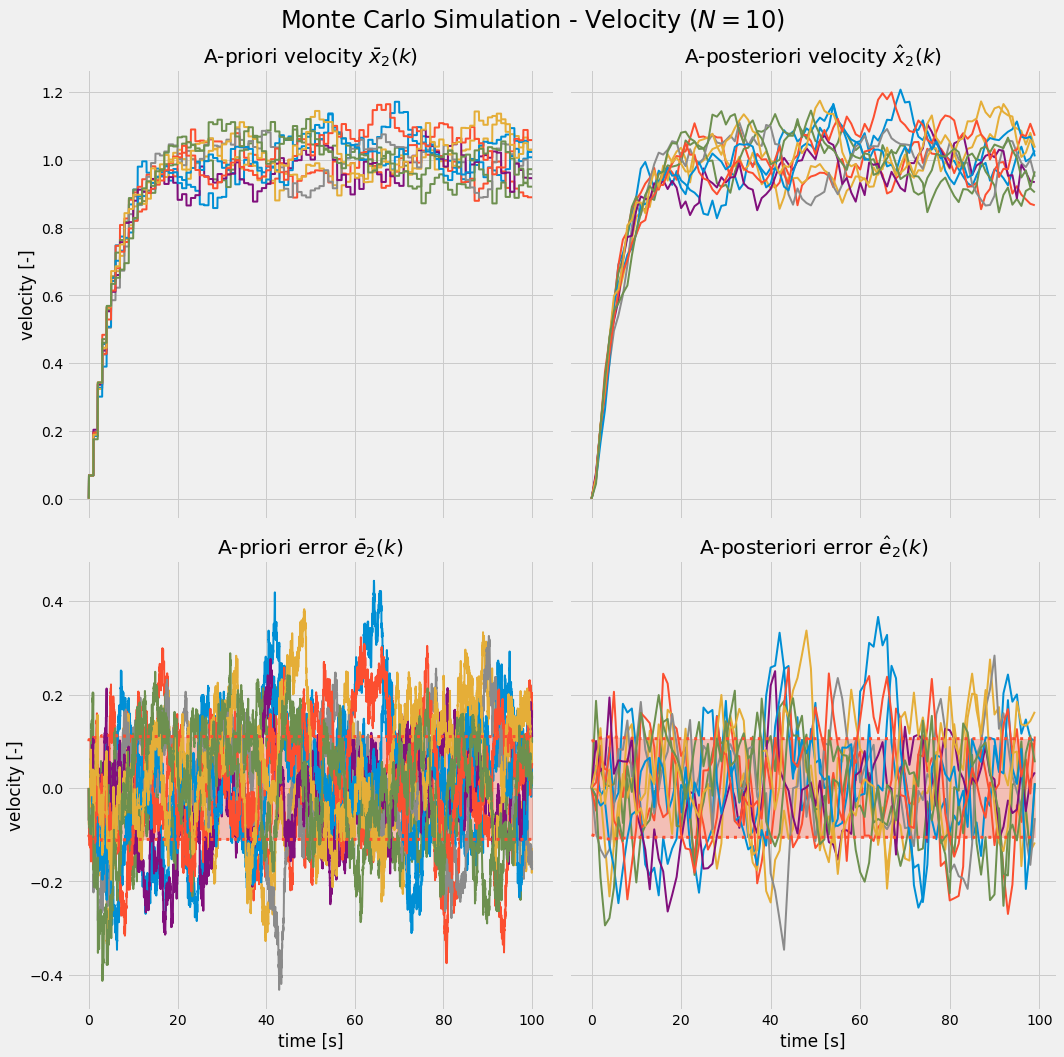

In [82]:
fig, axes = plt.subplots(ncols=2, nrows=2, sharex='col', sharey='row', figsize=(15,15))
fig.suptitle(r'Monte Carlo Simulation - Velocity ($N=10$)', fontsize=24)

tm = np.linspace(t0, tf, nm, endpoint=False)

ax = axes[0,0]
ax.set_title(r'A-priori velocity $\bar{x}_2(k)$')
ax.plot(t, X_bar[:,1,:].T, lw=2)
ax.set_ylabel('velocity [-]')

ax = axes[0,1]
ax.set_title(r'A-posteriori velocity $\hat{x}_2(k)$')
ax.plot(tm, X_hat[:,1,:].T, lw=2)

ax = axes[1,0]
ax.set_title(r'A-priori error $\bar{e}_2(k)$')
ax.plot(t, E_bar[:,1,:].T, lw=2)
ax.plot(t, sqrt(p_bar[1]), color=COLORS[1], lw=3, ls=':')
ax.plot(t, -sqrt(p_bar[1]), color=COLORS[1], lw=3, ls=':')
ax.fill_between(t, sqrt(p_bar[1]), -sqrt(p_bar[1]), color=COLORS[1], alpha=.3)
ax.set_ylabel('velocity [-]')
ax.set_xlabel('time [s]')

ax = axes[1,1]
ax.set_title(r'A-posteriori error $\hat{e}_2(k)$')
ax.plot(tm, E_hat[:,1,:].T, lw=2)
ax.plot(tm, sqrt(p_hat[1]), color=COLORS[1], lw=3, ls=':')
ax.plot(tm, -sqrt(p_hat[1]), color=COLORS[1], lw=3, ls=':')
ax.fill_between(tm, sqrt(p_hat[1]), -sqrt(p_hat[1]), color=COLORS[1], alpha=.3)
ax.set_xlabel('time [s]')

fig.tight_layout()
plt.show()

Below we see the calculated error mean $\hat{m}$ and standard deviation $\hat{p}_2^{1/2}$ together with the true Kalman filter standard deviation for $N=10, 100$ and $1000$. We see that as $N$ increases, the mean approaches zero, as expected, and that the calculated standard deviation places itself slightly above the Kalman filter value. This is also to expect (_Gelb_ p. 261 _"[...] filter covariance calculations are generally an optimistic indication of the accuracy of the filter."_).

100%|██████████| 1000/1000 [03:04<00:00,  5.43it/s]


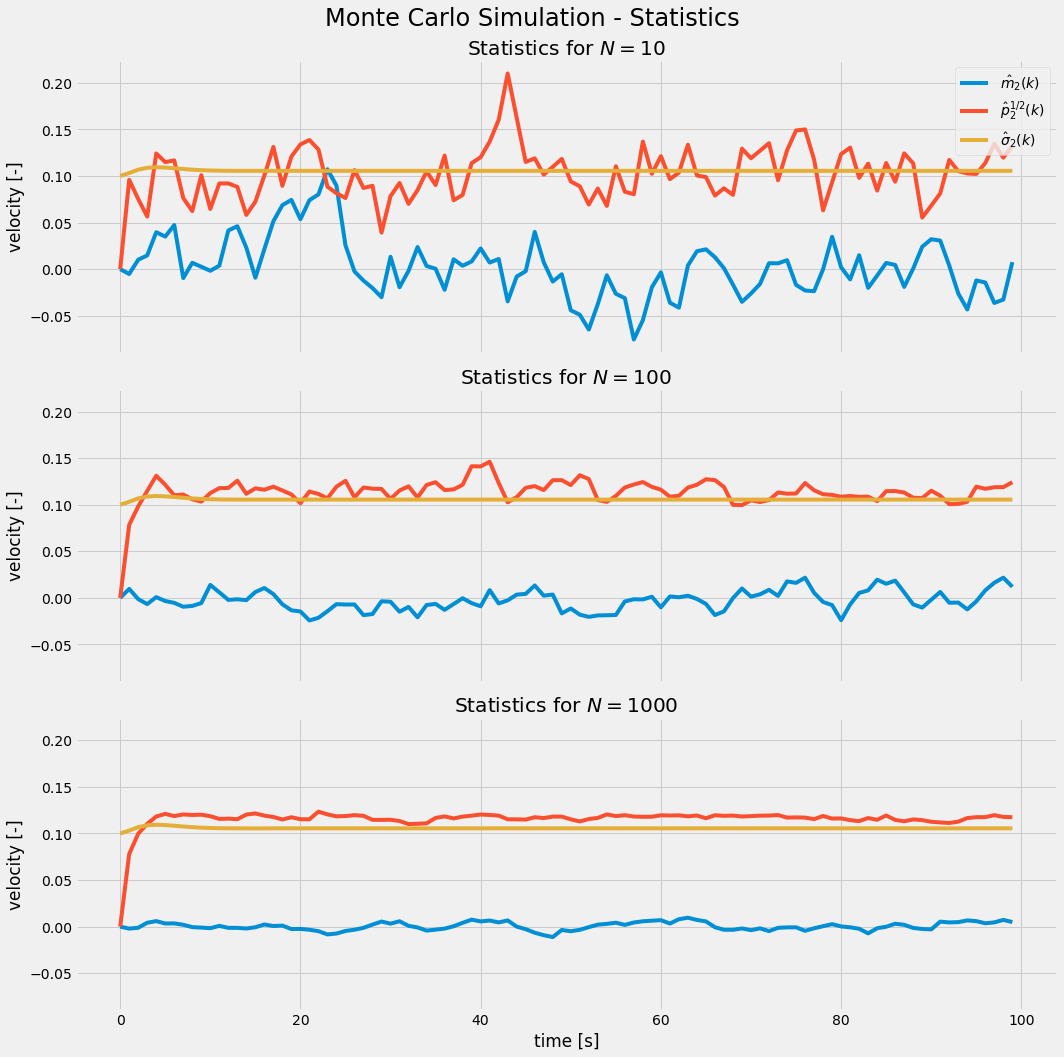

In [85]:
fig, axes = plt.subplots(ncols=1, nrows=3, sharex=True, sharey=True, figsize=(15,15))
fig.suptitle(r'Monte Carlo Simulation - Statistics', fontsize=24)

tm = np.linspace(t0, tf, nm, endpoint=False)

for i, N in enumerate((10,100,1000)):
    (X_bar, X_hat, E_bar, E_hat, p_bar, p_hat) = monte_carlo(N)
    
    ax = axes[i]
    ax.set_title(fr'Statistics for $N={{{N}}}$')
    ax.plot(tm, E_hat[:,1,:].mean(axis=0))
    ax.plot(tm, E_hat[:,1,:].std(axis=0))
    ax.plot(tm, sqrt(p_hat[1]))
    ax.set_ylabel('velocity [-]')

    if i == 0:
        ax.legend([r'$\hat{m}_2(k)$', r'$\hat{p}_2^{1/2}(k)$', r'$\hat{\sigma}_2(k)$'], loc='upper right')

    
ax.set_xlabel('time [s]')

fig.tight_layout()
plt.show()

# 6 Error budget for optimal Kalman filter

In [23]:
def kalman_gains(Fi, Ga, P0, H, R, n):
    # Model order
    p, _ = Fi.shape

    # A-posteriori covariance matrice estimates
    P_hat = np.zeros((n,p,p))

    # Kalman gains
    K = np.zeros((n,p,p))
    
    P_bar = P0
    for k in range(n):
        # Update a-posteriori estimate
        P_hat[k] = inv(inv(P_bar) + H.T@R@H)
        K[k] = P_hat[k]@H.T@inv(R)
        
        # Update a-priori estimate
        P_bar = Fi@P_hat[k]@Fi.T + Ga@Ga.T
        
    # Extract diagonals
    p_hat = np.array([P_hat[:,i,i] for i in range(p)])
    
    return (K, p_hat)

In [24]:
def covar_analysis(Fi, Ga, P0, H, R, K):
    
    # Model order
    n, p, _ = K.shape
    I = np.eye(p)

    # A-posteriori covariance matrice estimates
    P_hat = np.zeros((n,p,p))
    
    P_bar = P0
    for k in range(n):
        # Update a-posteriori estimate
        P_hat[k] = (I - K[k]@H)@P_bar@(I - K[k]@H).T + K[k]@R@K[k].T

        # Update a-priori estimate
        P_bar = Fi@P_hat[k]@Fi.T + Ga@Ga.T
        
    # Extract diagonals
    p_hat = np.array([P_hat[:,i,i] for i in range(p)])
    
    return p_hat

In [25]:
# Measurement update interval
mi = 100
nm = 101

# Kalman filter model matrices
FiK, _, GaK = c2d_stochastic(F, L, G, Q, dt*mi)
K, p_tot = kalman_gains(FiK, GaK, P0, H, R, nm)

In [26]:
p_all = covar_analysis(FiK, GaK, P0, H, R, K)

# P0 position
P0e = P0*np.array([[1],[0],[0]])
Gae = GaK*0
Re = R*0
p_P0_pos = covar_analysis(FiK, Gae, P0e, H, Re, K)

# P0 velocity
P0e = P0*np.array([[0],[1],[0]])
p_P0_vel = covar_analysis(FiK, Gae, P0e, H, Re, K)

# P0 armature current
P0e = P0*np.array([[0],[0],[1]])
p_P0_cur = covar_analysis(FiK, Gae, P0e, H, Re, K)

p_P0 = covar_analysis(FiK, Gae, P0, H, Re, K)

# Process noise
P0e = P0*0
Gae = GaK*1
Re = R*0
p_proc = covar_analysis(FiK, Gae, P0e, H, Re, K)

# Measurement noise
P0e = P0*0
Gae = GaK*0
Re = R*1
p_meas = covar_analysis(FiK, Gae, P0e, H, Re, K)

p_collection = [p_P0_pos, p_P0_vel, p_P0_cur, p_proc, p_meas]
p_sum = np.concatenate(p_collection).reshape(5,3,-1).sum(axis=0)
p_collection = [p_sum] + p_collection

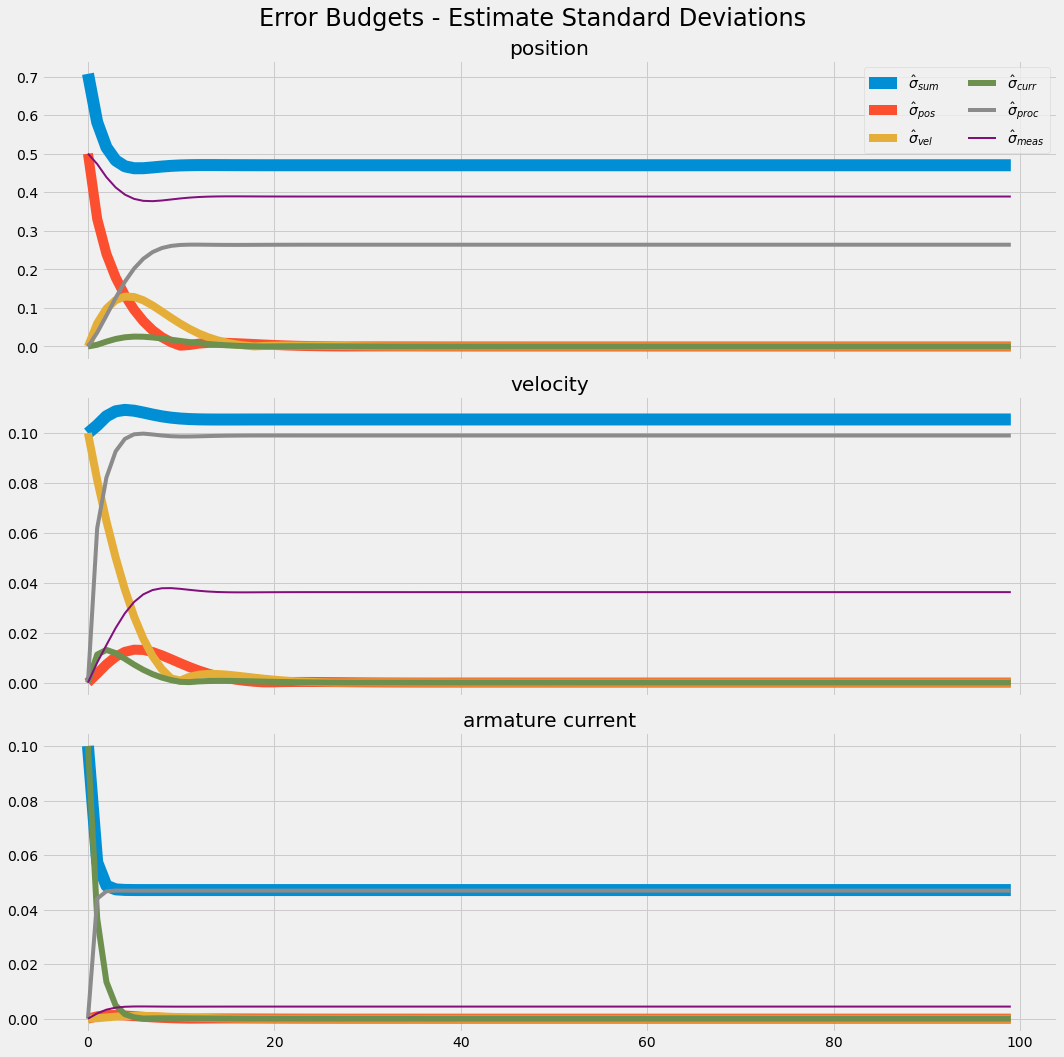

In [27]:
fig, axes = plt.subplots(ncols=1, nrows=3, sharex='col', sharey='row', figsize=(15,15))
fig.suptitle(r'Error Budgets - Estimate Standard Deviations', fontsize=24)

titles = ('position', 'velocity', 'armature current')
labels = (r'$\hat{\sigma}_{sum}$', r'$\hat{\sigma}_{pos}$', r'$\hat{\sigma}_{vel}$', r'$\hat{\sigma}_{curr}$', r'$\hat{\sigma}_{proc}$', r'$\hat{\sigma}_{meas}$')

tm = np.linspace(t0, tf, nm, endpoint=False)

for i, title in enumerate(titles):
    ax = axes[i]
    ax.set_title(rf'{title}')
    for j, arr in enumerate(p_collection):
        ax.plot(tm, sqrt(arr[i]), lw=12-2*j)
    if i == 0:
        ax.legend(labels, ncol=2)

fig.tight_layout()
plt.show()

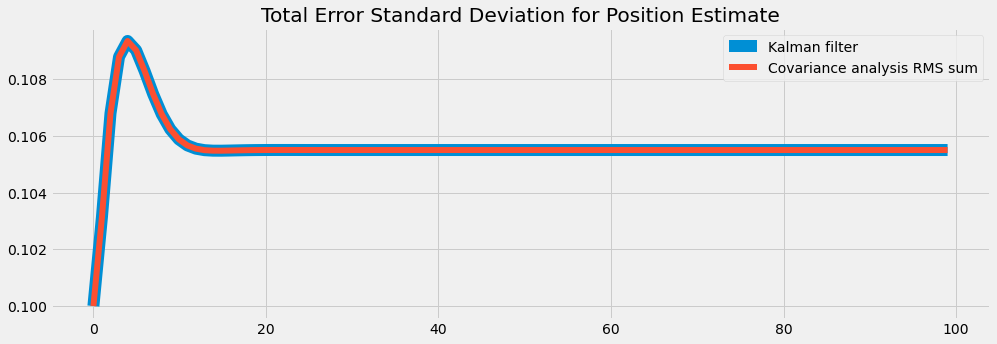

In [28]:
fig, axes = plt.subplots(ncols=1, nrows=1, sharex='col', sharey='row', figsize=(15,5))

ax = axes
ax.set_title(r'Total Error Standard Deviation for Position Estimate')
ax.plot(tm, sqrt(p_tot[1]), lw=12)
ax.plot(tm, sqrt(p_all[1]), lw=6)
ax.legend((r'Kalman filter', r'Covariance analysis RMS sum'))
plt.show()

# 7 Suboptimal Kalman filter

In [29]:
# Filter model matrices
Qf = T3/2*Q[:2,:2]
Ff = np.array([[0, 1],
               [0, -1/T2]])
Lf = np.array([[0, 0],
               [0, 1/T2]])
Gf = np.array([[0, 0],
               [0, 1/T2]])
P0f = np.diag([1,.1**2])

# Measurement parameters
Rf = 1*np.eye(2)
Hf = np.array([[1, 0],
               [0, 0]])

In [30]:
# Measurement update interval
mi = 100
nm = 101

# Kalman filter model matrices
FiK, LaK, GaK = c2d_stochastic(Ff, Lf, Gf, Qf, dt*mi)
variances = error_variance(FiK, GaK, P0f, Hf, Rf, nm)

NameError: name 'error_variance' is not defined

In [ ]:
std_tot_s = norm(variances, axis=0)
std_pos_s, std_vel_s = variances

In [ ]:
plt.plot(std_pos)
plt.plot(std_pos_s)
plt.yscale('log')